# Langzeit Scheduling

<b> Erkenntnisse: </b>
- Job-Reihenfolge im Solver ist relevant

In [14]:
import json
import random
import numpy as np
import pandas as pd

In [16]:
import pulp

In [18]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_interarrival as sit
import utils.schedule_solver__with_arrivals as ssv

In [20]:
pd.set_option('display.max_rows', 30)

In [22]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [24]:
def add_jobs_to_dict(job_set_dict, new_instance, shuffle=False, seed=50):
    offset = len(job_set_dict)
    items = list(new_instance.items())

    if shuffle:
        random.seed(seed)
        random.shuffle(items)

    for i, (_, ops) in enumerate(items):
        job_name = f"Job_{offset + i:03d}"
        job_set_dict[job_name] = ops

In [31]:
def generate_jobs_for_days(day_numb: int, jobs_instance: dict):
    jssp_data = {}

    # Schritt 1: Ursprüngliche Instanz vervielfachen (geschätzt mit Puffer)
    for i in range(int(2.3 *day_numb)):
        shuffle = False if (i % 2 == 0) else True
        add_jobs_to_dict(jssp_data, jobs_instance, shuffle)

    # Schritt 2: Zwischenankunftszeiten berechnen
    mean_interarrival_time = sit.calculate_mean_interarrival_time(jssp_data)
    df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(jssp_data, t_a=mean_interarrival_time)

    
    # Schritt 3a: Filter auf df_arrivals anwenden
    df_arrivals = df_arrivals[df_arrivals["Arrival"] <= (60 * 24 * day_numb)]
    df_arrivals

    # Schritt 3b: Nur die verbleibenden Job-IDs extrahieren
    valid_job_ids = set(df_arrivals["Job"])

    # Schritt 3c: jssp_data kürzen
    jssp_data = {job_id: ops for job_id, ops in jssp_data.items() if job_id in valid_job_ids}

    return jssp_data, df_arrivals


In [33]:
jssp_data, df_arrivals = generate_jobs_for_days(4, instance)
show.print_jobs(jssp_data)

Job_000:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_001:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_002:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_003:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_004:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_005:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

In [35]:
df_arrivals

,Job,Arrival
0,Job_000,0.00
1,Job_001,84.93
2,Job_002,106.18
3,Job_003,148.31
4,Job_004,185.08
...,...,...
84,Job_084,5519.69
85,Job_085,5542.52
86,Job_086,5591.92
87,Job_087,5644.29


In [ ]:
-

## I) Globalen Makespan minimieren
- Jobs werden nach Ankunftszeit sotiert (absteigend) da es bessere Resultate liefert

In [41]:
df_plan_global, makespan = ssv.solve_jssp_global_makespan(jssp_data, df_arrivals, solver_time_limit=3600, epsilon=0.06)
print(f"Makespan: {makespan} Minuten")

Makespan: 27373.28 Minuten


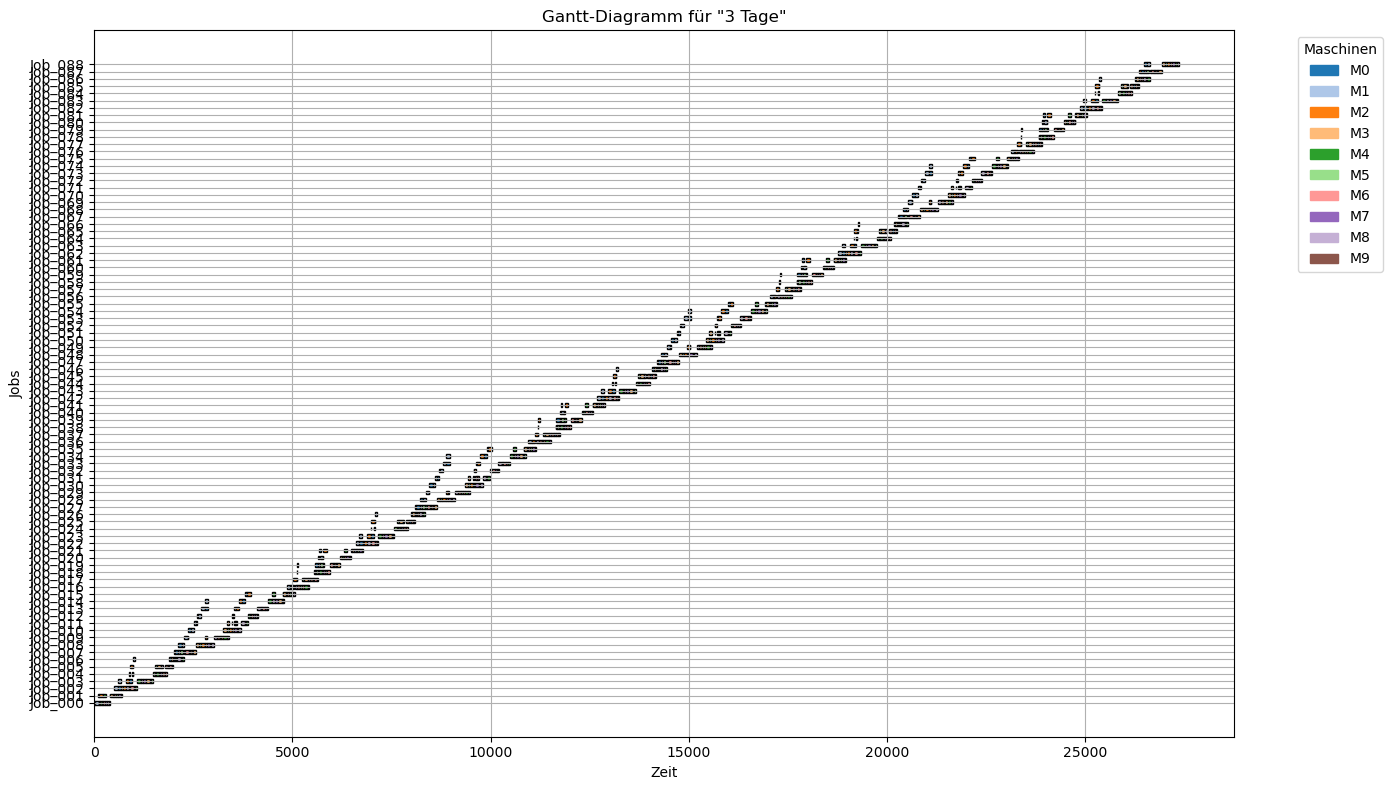

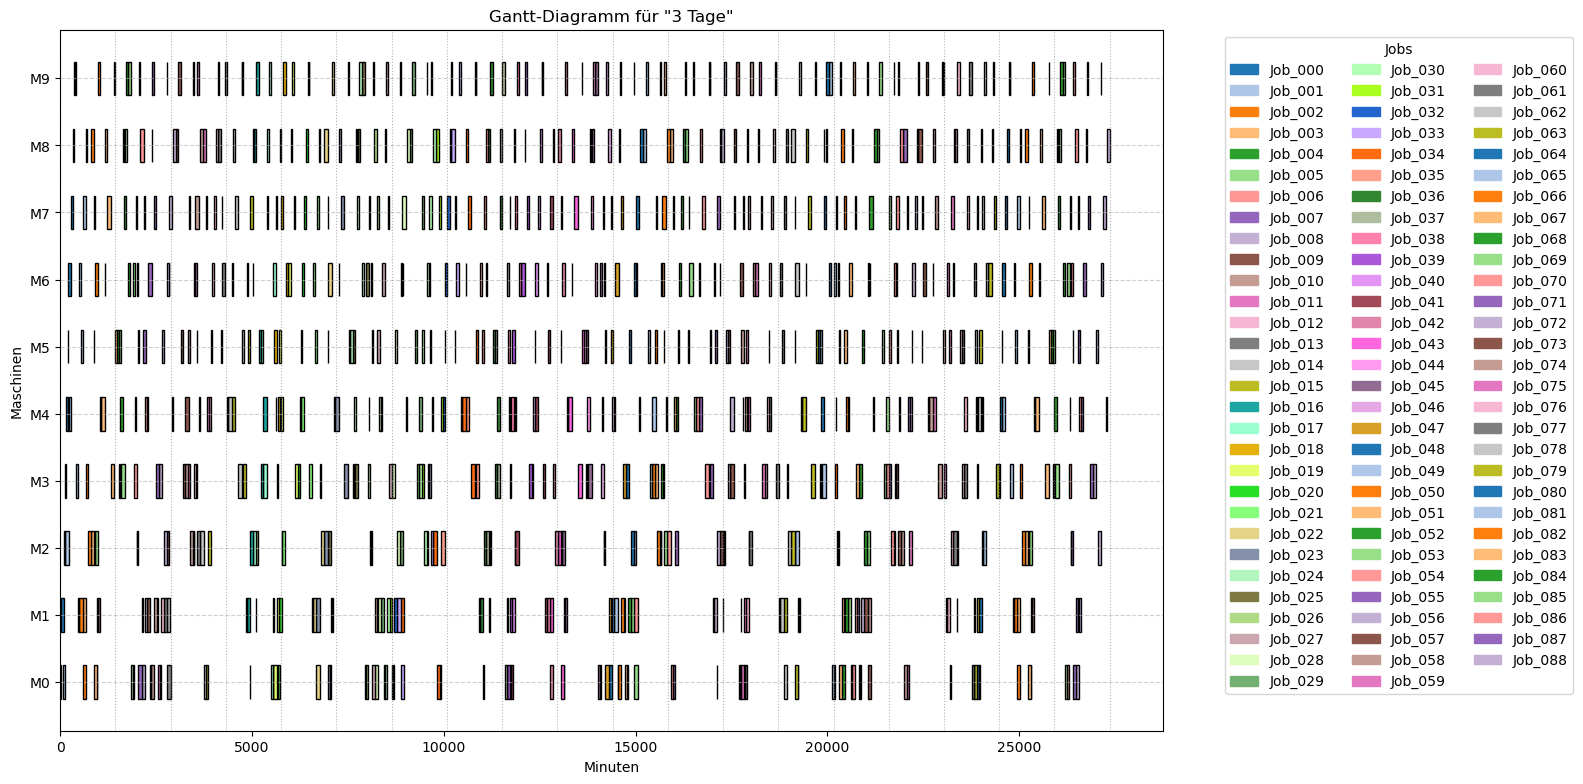

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [44]:
df = df_plan_global
category = "3 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

In [45]:
print(f"Globale Makespan:{max(df.End)}")

Globale Makespan:27373.28


In [46]:
df_job_flow = (
    df.groupby("Job")
    .agg({"Arrival": "first", "Start": "min","End": "max"})
    .rename(columns={"Arrival": "Arrival Time", "Start": "Start", "End": "Completion Time"})
    .reset_index()
)
df_job_flow

,Job,Arrival Time,Start,Completion Time
0,Job_000,0.00,0.00,395.00
1,Job_001,84.93,84.93,697.06
2,Job_002,106.18,503.12,1071.12
3,Job_003,148.31,594.18,1479.18
4,Job_004,185.08,887.24,1830.24
...,...,...,...,...
84,Job_084,5519.69,25240.04,26183.04
85,Job_085,5542.52,25254.10,26345.10
86,Job_086,5591.92,25341.16,26619.16
87,Job_087,5644.29,26360.22,26921.22


In [ ]:
df.to_csv("data/030_schedule_by_global_makespane.csv", index = False)

## II) Indivuelle Flowtimes minimieren
Flowtime eines Jobs = "Ende der letzen Operation des Jobs" - "Ankunftszeit des Jobs"

- Jobs werden nach Ankunftszeit sotiert (absteigend) da es bessere Resultate liefert

### A) Ungewichtet

In [50]:
df_plan_2a, total = ssv.solve_jssp_individual_flowtime(jssp_data, df_arrivals, solver_time_limit=120, epsilon=0.06)
print(f"Globale Makespan: {max(df_plan_2a.End)}")

Globale Makespan:27373.28


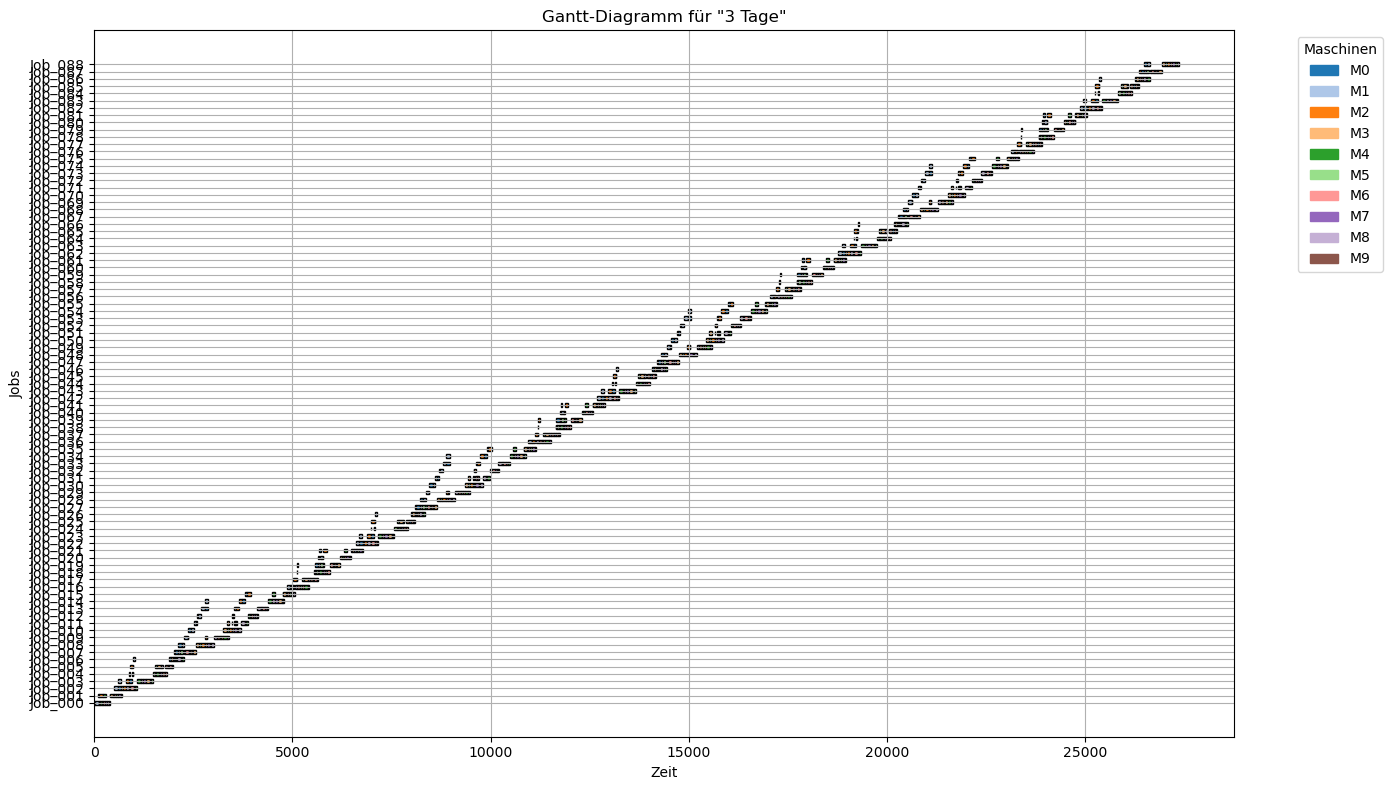

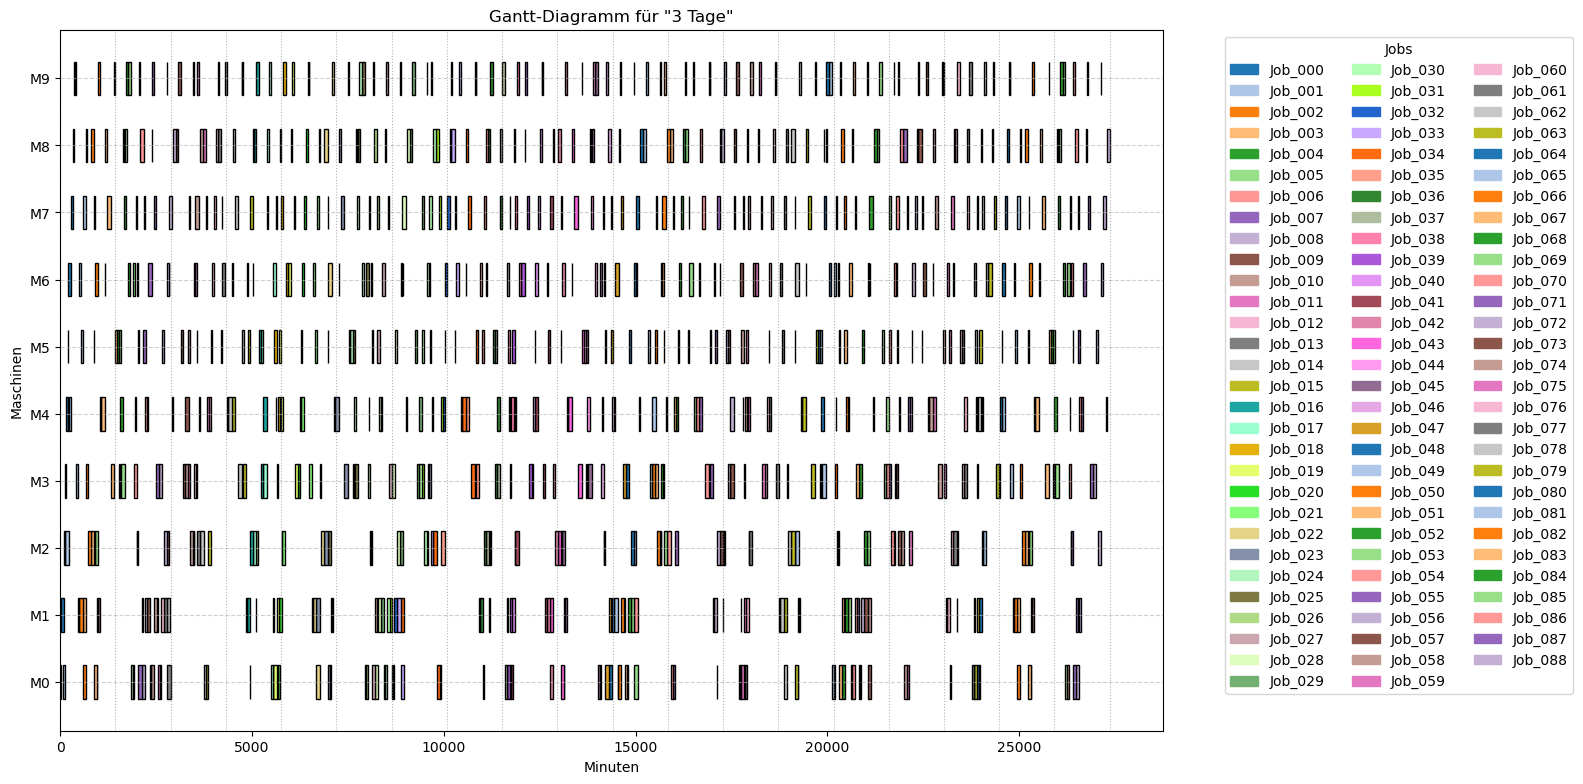

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [55]:
df = df_plan_2a
category = "3 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

In [ ]:
df_job_flow = (
    df.groupby("Job")
    .agg({"Arrival": "first", "Start": "min","End": "max"})
    .rename(columns={"Arrival": "Arrival Time", "Start": "Start", "End": "Completion Time"})
    .reset_index()
)
df_job_flow

In [ ]:
df.to_csv("data/03a_schedule_by_individual_flowtime.csv", index = False)

### B) Gewichtet (wenn früher arrival)

In [ ]:
df_plan_2b, total = ssv.solve_jssp_weighted_individual_flowtime(jssp_data, df_arrivals, solver_time_limit=1200, epsilon=0.06)
print(f"Globale Makespan:{max(df_plan_2b.End)}")

In [ ]:
df = df_plan_2b
category = "3 Tage"
show.plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

check.check_all_constraints(df, jssp_data)

In [ ]:
print(f"Globale Makespan:{max(df.End)}")

In [ ]:
df_job_flow = (
    df.groupby("Job")
    .agg({"Arrival": "first", "Start": "min","End": "max"})
    .rename(columns={"Arrival": "Arrival Time", "Start": "Start", "End": "Completion Time"})
    .reset_index()
)
df_job_flow

In [ ]:
df.to_csv("data/03b_schedule_by_individual_flowtime_weighted.csv", index = False)